# Mod 4 Project - Time Series Modeling - Zillow US Housing Prices

* Student name: John Cho
* Student pace: full time online
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL: 


# Time Series Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
import pickle
import itertools

# Import our datasets using pickle
with open('dft.pickle', 'rb') as f:
    dft = pickle.load(f)
with open('dft_roi.pickle', 'rb') as f:
    dft_roi = pickle.load(f)
display(dft.head(3), dft_roi)

,"60657 Chicago, IL","75070 McKinney, TX","77494 Katy, TX","60614 Chicago, IL","79936 El Paso, TX","77084 Houston, TX","10467 New York, NY","60640 Chicago, IL","77449 Katy, TX","94109 San Francisco, CA",...,"3765 Haverhill, NH","84781 Pine Valley, UT","12429 Esopus, NY","97028 Rhododendron, OR","12720 Bethel, NY","1338 Ashfield, MA","3293 Woodstock, NH","40404 Berea, KY","81225 Mount Crested Butte, CO","89155 Mesquite, NV"
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100


,Min_Max_ROI,1996_to_2018,Drop,Recovery,Months
"60657 Chicago, IL",2.042970,2.042970,0.201205,0.406245,52
"75070 McKinney, TX",0.697436,0.386003,0.135851,0.596830,27
"77494 Katy, TX",0.635847,0.573879,0.171263,0.401740,92
"60614 Chicago, IL",1.617100,1.594430,0.231924,0.419832,46
"79936 El Paso, TX",0.658060,0.559938,0.292517,0.108995,21
...,...,...,...,...,...
"1338 Ashfield, MA",1.283772,1.248939,0.169007,0.208852,50
"3293 Woodstock, NH",1.607507,1.393548,0.261977,0.252311,61
"40404 Berea, KY",1.287069,1.287069,0.164816,0.309593,41
"81225 Mount Crested Butte, CO",2.508201,2.508201,0.238338,0.373285,57


## Best Zip Codes Selection
Let's review our previously discussed strategy for answering the question: ***What are the top 5 best zip codes for us to invest in?***

* *Initially combine the top 5% (~750) of various ROI measures and filter out for the zip codes that only appear in every group.*
* *Create additional filters measuring risk and resilience to keep narrowing down the list.*
* *Finalize selection of the top 5 zip codes for different investing risk profiles.*
> **Months** and **Drop** are both negatively correlating metrics meaning lower is better. **Min-max** and **1996-2018** are quite similar with ~85% zip code duplication between them; filtering for both results in a selection of ~650 (vs ~750 individually). **Recovery** is similar to **1996-2018** as ROI is calculated to the same end date but in half the timeframe, while helping to eliminate any 'artificial uplifting' of housing prices from the bubble prior to the crash.

As we saw in the previous notebook, we were able to narrow down to a top 10 using 4 out of 5 of our filters. Upon closer inspection, the rather low 9.98% threshold for 'Drop' is likely capturing zip codes that did not rise nearly as much as others during the housing bubble (and hence did not fall as much).
> According to [Forbes](https://www.forbes.com/sites/kirandhillon/2014/08/01/heres-a-look-at-the-housing-market-eight-years-after-the-collapse-3/#340a4af53853), the median US home price drop during the 2008 housing crash was 29%.

In [2]:
print(f'Min_Max: {dft_roi.Min_Max_ROI.quantile(q=0.95)}')
print(f"1996_to_2018: {dft_roi['1996_to_2018'].quantile(q=0.95)}")
print(f'Months: {dft_roi.Months.quantile(q=0.05)}')
print(f'Drop: {dft_roi.Drop.quantile(q=0.05)}')
print(f'Recovery: {dft_roi.Recovery.quantile(q=0.95)}')

# Saving top 10 into new dataframe
dft_roi_zips = dft_roi[dft_roi.Min_Max_ROI>=2.94][dft_roi['1996_to_2018']>=2.78][dft_roi.Months<=22
                                                                                ][dft_roi.Recovery>=1.003].index
dftop = dft.loc[:, dft_roi_zips]
dftop

Min_Max: 2.9433556760151385
1996_to_2018: 2.781253264698858
Months: 22.0
Drop: 0.09983007010943913
Recovery: 1.0031216484729653


,"90034 Los Angeles, CA","94610 Oakland, CA","94061 Redwood City, CA","19125 Philadelphia, PA","90404 Santa Monica, CA","94402 San Mateo, CA","94702 Berkeley, CA","94618 Oakland, CA","90232 Culver City, CA","94709 Berkeley, CA"
Date,,,,,,,,,,
1996-04-01,231300,307600,301600,32600,237400,411200,160600,315900,229000,268900
1996-05-01,231700,307500,302000,32700,238300,411500,161000,316800,229900,270400
1996-06-01,232100,307400,302500,32800,239300,412200,161500,317800,230700,272000
1996-07-01,232400,307400,303300,32800,240300,413300,162100,318900,231600,273600
1996-08-01,232700,307300,304400,32900,241400,414700,162700,320300,232600,275200
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1368500,1500400,1635400,257100,1467700,1972700,995100,1664700,1349800,1497400
2018-01-01,1382700,1521800,1667700,258000,1475200,2002900,1006300,1691600,1354100,1507700
2018-02-01,1398000,1536400,1691800,258500,1490300,2025100,1017300,1711500,1360400,1517300


### Our top 10 are quite homogenous (9 in CA) which can be a bad thing if diversification is a goal. Let's see what their plots look like and how well they correlate with each other.

,"90034 Los Angeles, CA","94610 Oakland, CA","94061 Redwood City, CA","19125 Philadelphia, PA","90404 Santa Monica, CA","94402 San Mateo, CA","94702 Berkeley, CA","94618 Oakland, CA","90232 Culver City, CA","94709 Berkeley, CA"
"90034 Los Angeles, CA",1.000000,0.982215,0.964779,0.955427,0.989458,0.963568,0.988465,0.977658,0.997711,0.976670
"94610 Oakland, CA",0.982215,1.000000,0.984014,0.926210,0.980272,0.975165,0.995375,0.996571,0.984631,0.995109
"94061 Redwood City, CA",0.964779,0.984014,1.000000,0.932492,0.974972,0.994185,0.983871,0.992118,0.970997,0.987639
"19125 Philadelphia, PA",0.955427,0.926210,0.932492,1.000000,0.959489,0.944503,0.936975,0.933491,0.957901,0.934799
"90404 Santa Monica, CA",0.989458,0.980272,0.974972,0.959489,1.000000,0.980693,0.989824,0.979782,0.992424,0.980054
"94402 San Mateo, CA",0.963568,0.975165,0.994185,0.944503,0.980693,1.000000,0.982205,0.983087,0.970164,0.981270
"94702 Berkeley, CA",0.988465,0.995375,0.983871,0.936975,0.989824,0.982205,1.000000,0.992389,0.989999,0.991545
"94618 Oakland, CA",0.977658,0.996571,0.992118,0.933491,0.979782,0.983087,0.992389,1.000000,0.982731,0.996928
"90232 Culver City, CA",0.997711,0.984631,0.970997,0.957901,0.992424,0.970164,0.989999,0.982731,1.000000,0.981248
"94709 Berkeley, CA",0.976670,0.995109,0.987639,0.934799,0.980054,0.981270,0.991545,0.996928,0.981248,1.000000


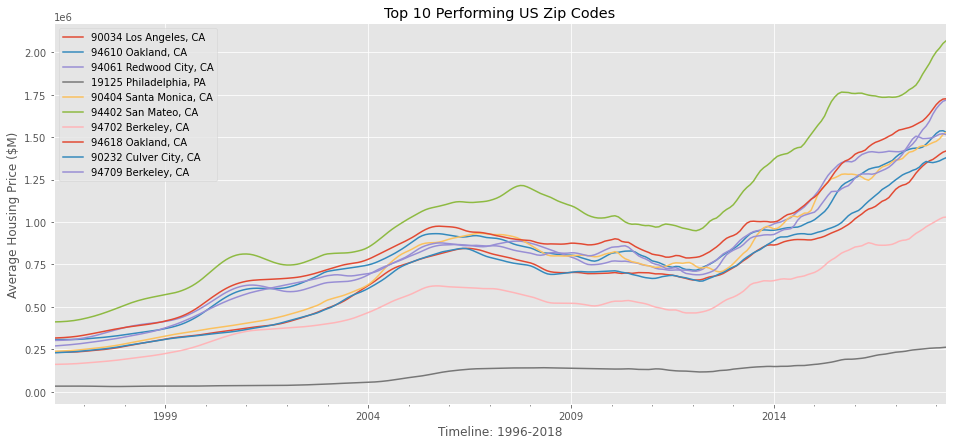

In [3]:
plt.style.use('ggplot')
dftop.plot(figsize=(16,7), title='Top 10 Performing US Zip Codes')
plt.ylabel('Average Housing Price ($M)')
plt.xlabel('Timeline: 1996-2018')
dftop.corr()

### As expected, these top 10 zip codes are highly correlated with other. Our lone non-California zip code looks almost flat by comparison due to scale but we can see 93-95% correlation with the rest of the group.
> Philadelphia, PA enjoyed the advantage of an extremely low cost basis in 1996 - almost ***one tenth*** of some of its peers!

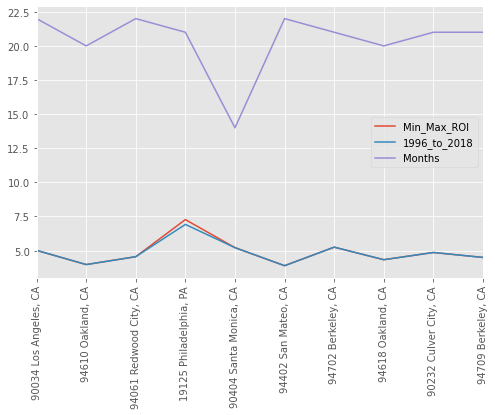

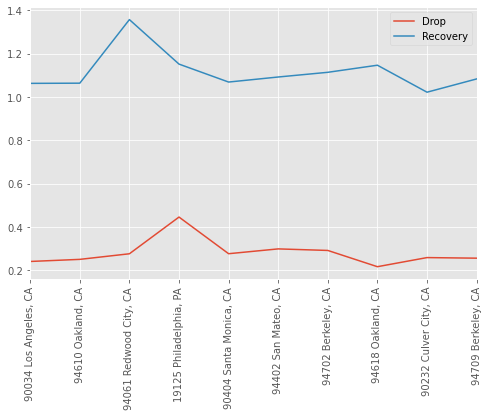

In [4]:
# View ROI metrics of our top 10
dft_roi.loc[dft_roi_zips,:].drop(columns=['Drop','Recovery']).plot(figsize=(8,5), rot=90);  #separating due to scale
dft_roi.loc[dft_roi_zips,:].drop(columns=['Min_Max_ROI','1996_to_2018','Months']).plot(figsize=(8,5), rot=90);

# Time Series Modeling
* **Requirements**: our data must be stationary - meaning its statistical properties such as mean, variance, standard deviation remain constant over time. It must also be 'non-trending' - as previously established, our data has a clear upward linear trend and therefore must be 'de-trended.'

We will use the **Dickey-Fuller** test to test for stationarity. In order to transform and detrend our data, we can employ various methods: **log transformation, square root, differencing, rolling means, time series decomposition.**

In [5]:
# Function to evaluate time series stationarity using rolling mean, standard deviation and Dickey Fuller test
def stationarity_check(df):
    roll_mean = df.rolling(window=3, center=False).mean()
    roll_std = df.rolling(window=3, center=False).std()
    dftest = adfuller(df[df.columns[0]])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,4))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

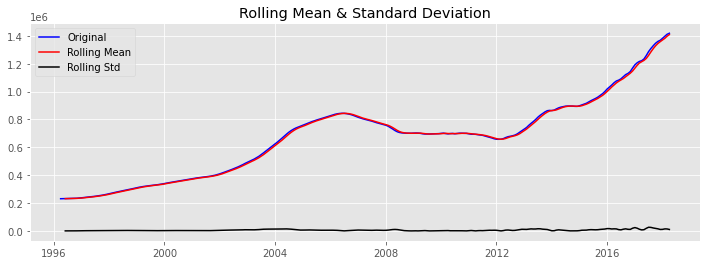

Results of Dickey-Fuller Test: 

Test Statistic                  -0.097219
p-value                          0.949715
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


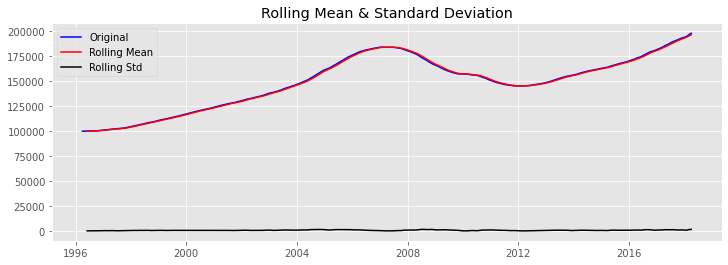

Results of Dickey-Fuller Test: 

Test Statistic                  -1.341032
p-value                          0.610197
#Lags Used                       2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


In [6]:
# Establish stationarity baselines using first zip code in top 10 (90034 Los Angeles, CA) and median yearly prices for
# entire dataset
stationarity_check(dftop.iloc[:,:1])
dft_median = pd.DataFrame(dft.T.median())  #new dataframe with single column of median values for each year
stationarity_check(dft_median)

### The visual plots and high p-values indicate a strong likelihood of the null hypothesis being true: that the data is non-stationary. We need a p-value of 0.05 or lower to confirm stationarity. Now let's try out some transformation techniques.

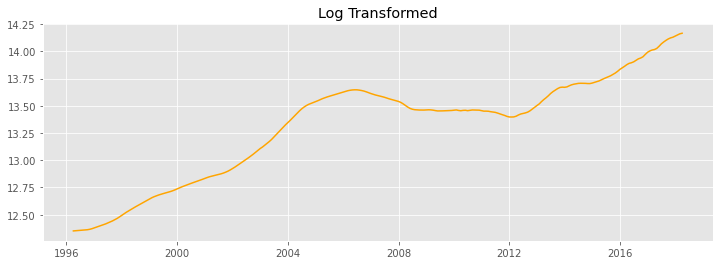

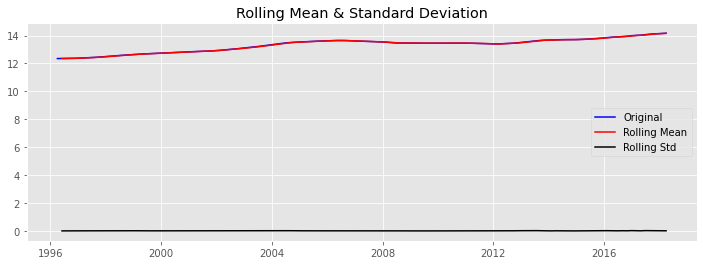

Results of Dickey-Fuller Test: 

Test Statistic                  -1.355672
p-value                          0.603334
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [7]:
# Perform log transformation and stationarity checks
dft_log = pd.DataFrame(dftop[dftop.columns[0]].apply(lambda x: np.log(x)))
plt.figure(figsize=(12,4))
plt.plot(dft_log, color='orange')
plt.title('Log Transformed')
plt.show();
stationarity_check(dft_log)

#### Some improvement.. let's try adding the rolling mean with a window size of 3 months (quarterly).

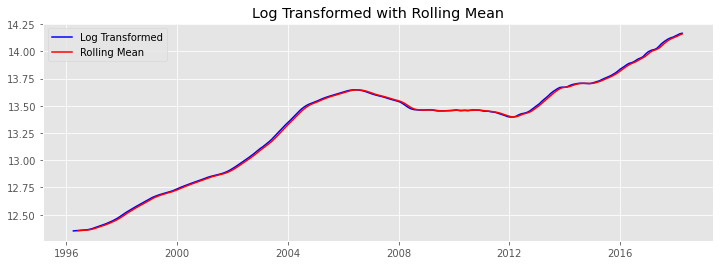

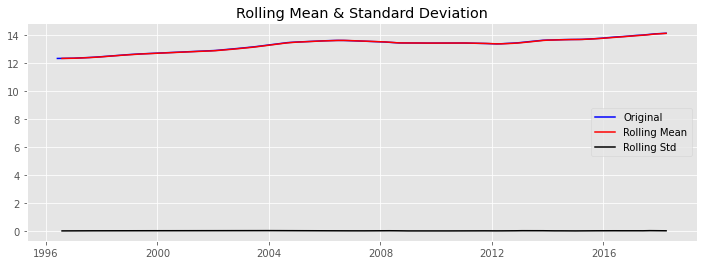

Results of Dickey-Fuller Test: 

Test Statistic                  -1.211498
p-value                          0.668630
#Lags Used                      16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


In [8]:
# Calculate rolling mean using window size 3
roll_mean = dft_log.rolling(window=3).mean().dropna()
plt.figure(figsize=(12,4))
plt.plot(dft_log, color='blue', label='Log Transformed')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed with Rolling Mean')
plt.show(block=False)
stationarity_check(roll_mean)

#### P-value got a little worse! Let's try subtracting the rolling mean from the log transformed values.

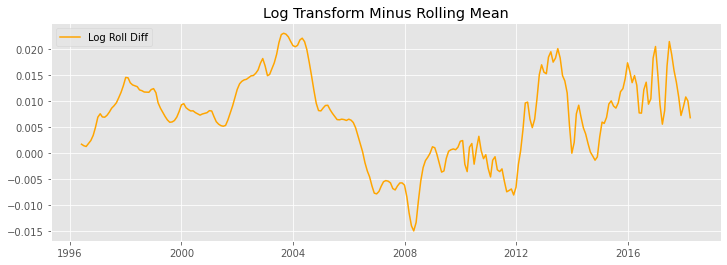

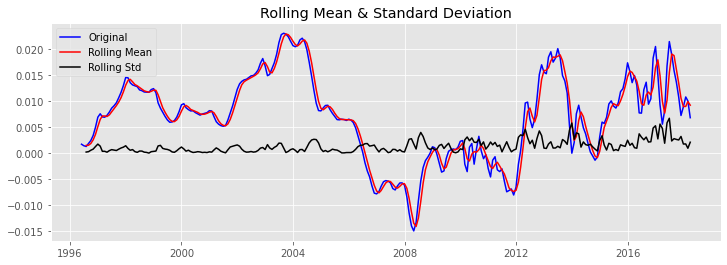

Results of Dickey-Fuller Test: 

Test Statistic                  -2.335163
p-value                          0.160878
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [9]:
# Subtract the moving average from the log transformed data
dft_log_roll_diff = dft_log - roll_mean
dft_log_roll_diff = dft_log_roll_diff.dropna()
# Plot the result
plt.figure(figsize=(12,4))
plt.plot(dft_log_roll_diff, color='orange',label='Log Roll Diff')
plt.legend(loc='best')
plt.title('Log Transform Minus Rolling Mean')
plt.show(block=False)
stationarity_check(dft_log_roll_diff)

#### Getting better.. let's see happens if we take the square root instead and subtract the *weighted* rolling mean.

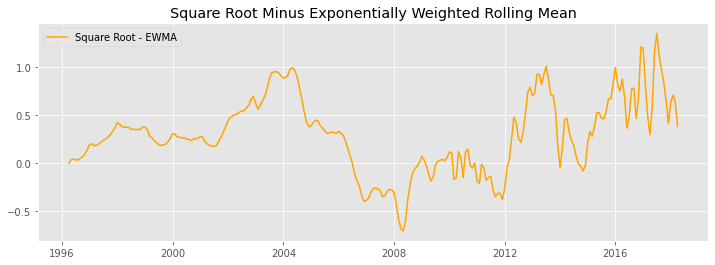

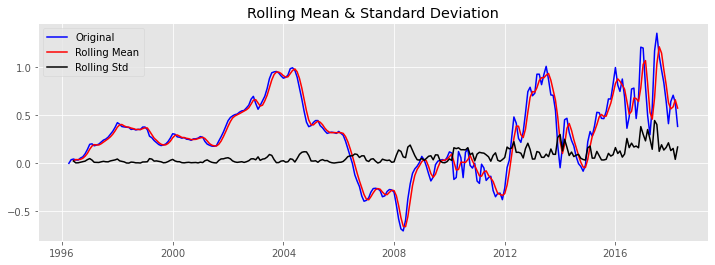

Results of Dickey-Fuller Test: 

Test Statistic                  -2.570018
p-value                          0.099354
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [10]:
# Square root transform
dft_sqrt = pd.DataFrame(dftop[dftop.columns[0]].apply(lambda x: np.sqrt(x)))

# Subtract the weighted rolling mean (exponential weighted moving average) and plot
# Note that p-values improve with lower halflife
dft_sqrt_ewma = dft_sqrt.ewm(halflife=0.3).mean()
dft_sqrt_ewma_diff = dft_sqrt - dft_sqrt_ewma

plt.figure(figsize=(12,4))
plt.plot(dft_sqrt_ewma_diff, color='orange', label='Square Root - EWMA')
plt.legend(loc='best')
plt.title('Square Root Minus Exponentially Weighted Rolling Mean')
plt.show(block=False)
stationarity_check(dft_sqrt_ewma_diff)

#### Almost there! We have removed most of the upward trend but not the seasonality. Let's 'difference' the data with a lag of 12 (months).

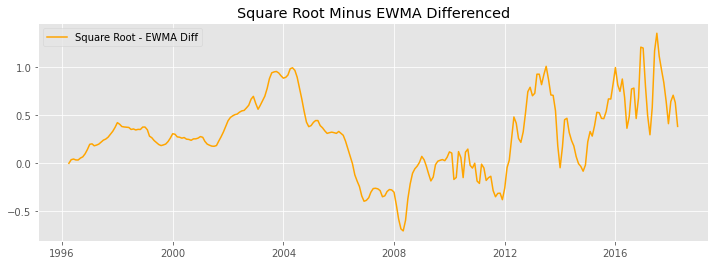

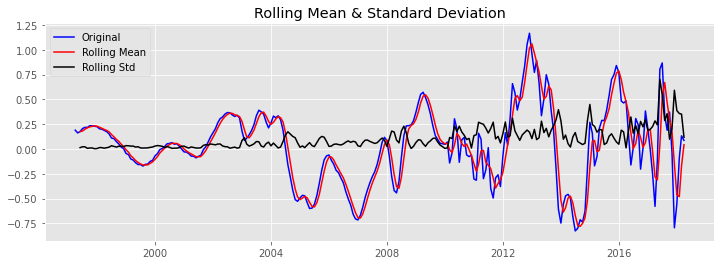

Results of Dickey-Fuller Test: 

Test Statistic                  -2.962739
p-value                          0.038524
#Lags Used                      16.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


In [11]:
# Difference the transformed data
dft_diff = dft_sqrt_ewma_diff.diff(periods=12)
dft_diff.dropna(inplace=True)  #drop missing values
plt.figure(figsize=(12,4))
plt.plot(dft_sqrt_ewma_diff, color='orange', label='Square Root - EWMA Diff')
plt.legend(loc='best')
plt.title('Square Root Minus EWMA Differenced')
plt.show(block=False)
stationarity_check(dft_diff)

### This would be considered stationary enough to perform time series modeling!
Before moving on, let's try the final method for removing trends, seasonality and increasing stationarity: ***Time Series Decomposition***.

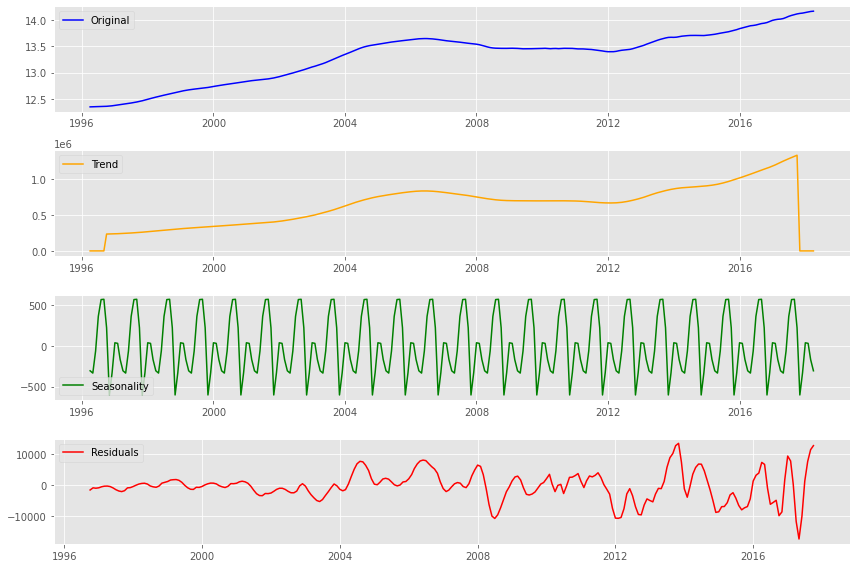

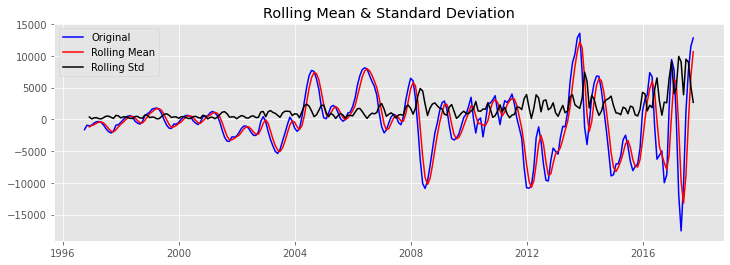

Results of Dickey-Fuller Test: 

Test Statistic                  -4.889936
p-value                          0.000036
#Lags Used                      10.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


In [12]:
# Perform seasonal_decompose function from statsmodels using default additive model
decomposition = seasonal_decompose(dftop.iloc[:,:1])

# Gather the trend, seasonality, and residuals separated out
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid
residuals = residuals.dropna()  #remove nulls generated by differencing
trend = trend.fillna(0)  #fill nulls in with 0

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(dft_log, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuals, label='Residuals', color='red')
plt.legend(loc='best')
plt.tight_layout()

stationarity_check(residuals.dropna())

#### Now that is an even better p-value! What's convenient about this method is that the data has been split into 3 groups that separate the trend and seasonality patterns from the residuals, or the 'noise' that would be considered more random.
### We can create a time series prediction model from the residuals and convert back to values in US dollars by simply adding back the trend and seasonality.
One final characteristic we'll need to confirm is that the values of our residuals are normally distributed. We'll also look at the Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF) to help determine model parameters.

<Figure size 864x432 with 0 Axes>

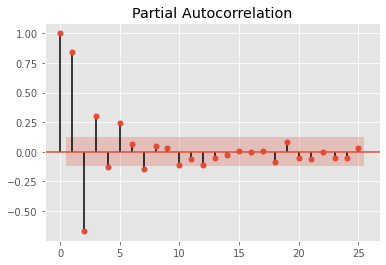

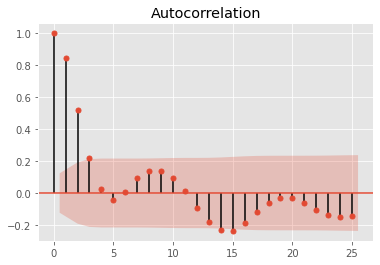

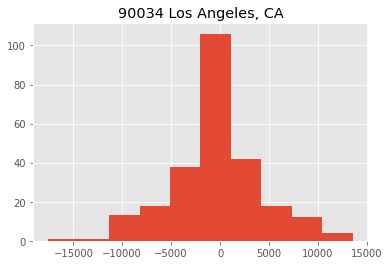

In [13]:
# Plot PACF, ACF
plt.figure(figsize=(12,6))
plot_pacf(residuals);
plot_acf(residuals);

# Confirming normal distribution
residuals.hist();

#### Normality looks good and the ACF/PACF plots indicate what range of parameters we should fit to our model.
---

## The ARIMA (AutoRegressive Integrated Moving Average) Time Series Model

**Number of AR terms (p)**: p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

**Number of Differences (d)**: d is the Integrated component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last n days is small.

**Number of MA terms (q)**: q is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

(p, d, q) are the non-seasonal parameters described above.
(P, D, Q) follow the same definition but are applied to the seasonal component of the time series.
The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc. - we will use s=12).

We will be ranking the different parameter models using the **Akaike Information Criterion (AIC)**: an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The best model would have the lowest AIC score and we will use its parameters to build a **SARIMAX (Seasonal ARIMA with eXogenous regressors)** prediction model.

In [14]:
# Define the p, d and q parameters to take any value between 0 and 2 then generate every combination using itertools.product
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Generate combos for seasonal p, d, q parameters
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

# Run a grid with pdq and seasonal pdq parameters calculated above to find best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(residuals,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            
# Print optimal parameters with the lowest AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4971.4637329893085
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4745.449613973643
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4513.000518048122
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4908.475469225103


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4580.562825562201


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4366.957012209906
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =4890.006786003667


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4529.121661038301


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4285.550219433202
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4764.315925532945


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4724.175754663403


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =4505.710408407794
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4648.559064006873


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4561.909437237233


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =4294.353833415649


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated =4567.754572686432


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated =4407.009926292079


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated =4219.242879154785
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =4533.331330243805


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =4514.788956647706


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated =4503.516537412242


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated =4385.436532430793


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated =4336.21374774648


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated =4327.61065505935


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated =4266.079398628923


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated =4197.026425141725


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated =4178.61767079546


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4700.799733730491


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4443.408068805425


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated =4225.868535828895


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4656.536748313845


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4387.70896289164


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated =4161.4862109762735


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated =4651.346915196333


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated =4362.601206651116


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated =4113.147838536082


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4520.167013301474


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4431.257142486191
ARIMA (0, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated =4262.509209840686


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4448.654265567471


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4389.261415278906


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated =4029.8844301646977


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated =4419.390873131794


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated =4357.999139241345


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated =4114.959377533829


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =4300.613958069669


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =4299.727729034172


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated =4246.3563738211
ARIMA (0, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated =4211.016638721211


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated =4061.9552895033826


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated =4049.0518378510988


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated =4166.683497790764


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated =4034.3359238384337


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated =4116.101868053441


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =4498.636418725762


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =4288.84440784035


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated =4078.1503527559425


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated =4486.277905395953


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =3993.4845349674383


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated =3803.8063410109835


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated =4510.418966640274


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated =3936.3610997980472


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated =4010.8414936030576


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =4248.111468094233


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =4197.037601795817


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated =3997.7659865074593


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated =4128.063920245089


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated =3992.935416309981


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated =3793.756808614611


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated =4069.445352968656


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated =3894.836773208262


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated =4013.7712605575075


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated =4062.2294904425858
ARIMA (0, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated =4137.931805050768


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated =4081.7451172234723


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated =3897.2984809464483


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated =3922.4329349900213


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated =3911.88291961137


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated =3809.5449304474428


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated =3719.8424711189923


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated =3919.144741658671
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4634.310017002454


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4424.957113181744


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =4210.5199755101
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4546.2170699431335

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4232.809197918165


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =4024.001865553591


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4513.430369423856


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =4125.406766818588


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3967.9051999294893
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4442.9890125853235


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4412.76480676782


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated =4196.664145607623
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4306.8519815715

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4250.483259080071


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =4045.1432583077376


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4188.52097169497


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =4115.525003386105


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3901.5547170131754
ARIMA (0, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated =4232.09475726733

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated =4214.797393415329


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =4169.2674966204795
ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =4090.206235584321


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =4052.8386966953876


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =4046.3170512380575


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3939.169332634538


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3891.9369000235315


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3897.018761675888
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4432.823145286483

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4229.972427060195


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4026.878359419813


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4331.1927166179585


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4053.1933295127237


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3848.045086505773


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4307.017883648021


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3990.6166084922033


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3755.4063503984057


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4264.285135640299


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4208.934524716869


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4027.5391014497445


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4122.0114910472175


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4054.8323657024575


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3823.184602773864


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4015.001797173847


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3895.928687923145


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3664.1463416872607


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4049.4533254396324


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4046.1481744120456
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4025.5476729526126


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3905.851050311642


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3857.84637785958


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3809.8870043844463


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3812.849836065987


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3721.037214980507


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3690.7336324099615
ARIMA (0, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated =4354.905080477716


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated =4121.0590592819935


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated =4009.0931842493655


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =4244.53266838572


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3897.3673375280237


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3699.418358606772


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4233.80916431442


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3833.985430889209


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3540.898703286681


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated =4171.978482263893


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated =4144.028653977852


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated =4011.0945786501693


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =4001.1503101834587


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3894.9590954645614


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3699.609205324237


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3997.8818092371575


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3775.373515659744


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3540.734657094318


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =3973.448823506318


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =3991.2094438209506


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =4008.0851003635808


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3788.781666217852


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3748.8629080042756


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3701.1932638201597


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3676.651696350506


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3614.425383632137


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3685.736989667056
ARIMA (0, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =4566.5691710840565


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =4356.416723729002


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated =4152.42092336554
ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4492.212785994241


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =4200.63906583793


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =4004.139278765305


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4470.398632069042


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =4128.90116914833


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3786.25329990418
ARIMA (0, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =4374.690302163031


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =4352.803041157244


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =4143.512604315085
ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =4234.670293601981


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =4167.634858883865


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3955.6234591593907


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =4123.979906608813


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =4022.8303644370635


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3837.862719488743
ARIMA (0, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =4168.150304996252

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA (0, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =4161.800556811397


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated =4123.644053958879
ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =4021.142575130131


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3977.5132816175797


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3957.6021072589033


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3869.8358275590126


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3836.340653535724


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3825.5926688402233
ARIMA (0, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =4459.802541053314


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =4253.316028849797


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated =4049.490621636891
ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =4394.702553531906


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =4055.8257263731366


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3847.4558178148664


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4384.30039802915


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3981.963938558504


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3821.313599614043


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =4288.465486352137


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =4246.375502339524


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =4051.0544339405924


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =4147.449144632546


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =4051.8251834456364


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3833.2526150656518


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =4059.289712585435


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3924.6821962499157


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3727.237839900458


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =4082.4636206873097


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =4084.283129680722


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated =4046.164959029982


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3953.8031651389


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3881.714075429537


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3825.8472535877663


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3802.625242346129


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3744.5055509305434


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3713.563133095509


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =4417.0734924752705


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =4194.194897363414


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =3991.1565591510907


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4313.515789940229


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3998.367861639408


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3843.6535194900707


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4292.015842901697


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3904.623317440044


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3635.5090413204334


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4245.284000844726


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4195.925390054339


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3991.7741998831925


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4127.949000547311


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3999.6788412794053


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3842.3227430039706


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4002.1478423050285


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3868.8669731769064


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3638.790535515055


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =4042.808669952532


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4042.658032172386


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3990.87793629055


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3893.3368097177695


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3848.363708021954


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3811.42078797409


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3836.301031258853


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3711.050349850045


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3723.5703632157856
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4638.805674082286


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4429.560604133418


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4206.574709432163


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4556.528497239294


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4260.080180533565


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4046.3806730594774


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =4524.4562380283205


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4183.2456132287025


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =3938.1651684347707
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4430.320529905312


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4412.601980270663


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =4201.347712542549


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4301.778373145234


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4261.663896212337


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =4045.1475877628727


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated =4205.845029836279


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated =4103.903530237993


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated =3861.3734197072567


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =4219.272895946105


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =4199.354339161444


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated =4188.628827324121


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated =4083.3430479673116


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated =4030.7288090570464


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated =4007.7639787865314


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated =3964.181946897843


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated =3885.966977323452


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated =3862.4164176331033
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4430.588212262859

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4228.858872874709


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated =4012.524211042707


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4341.88653268168


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4023.538730793178


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated =3824.9356333500273


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated =4322.612279216679


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated =3938.779546308492


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated =3665.2825418647917


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4245.975740923328


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4228.962356212703


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated =4011.9385931366814


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4101.701750755066


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4024.3825160846573


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated =3824.159110555629


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated =4006.2838969395725


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated =3902.0344226679504


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated =3667.717383999662


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =4030.1297809168054


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =4044.5315934759606


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated =4013.188291423419


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated =3908.080234193746


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated =3839.5651296592887


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated =3809.976356613297


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated =3766.8851166448453


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated =3708.61869755161


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated =3696.868306930148
ARIMA (1, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =4302.196870163642

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA (1, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =4098.727562131737


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated =3908.9462592465716


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated =4216.455678245358


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =3876.320690341986


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated =3680.806915673231


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated =4220.179683570171


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated =3820.391784638752


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated =3527.342741416942


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =4138.733950591331


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =4061.657944011933
ARIMA (1, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated =3892.2813402821357


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated =3969.084697996445


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated =3874.3086516780977


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated =3679.8103412976816


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated =3905.0668507718565


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated =3763.5139874765505


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated =3526.90788008666


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated =3937.138594681031


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated =3922.2480869613632


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated =3886.6582703606437


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated =3756.3944111595483


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated =3712.4304568292346


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated =3693.2873823445643


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated =3655.220357727455


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated =3584.6729966037683


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated =3572.952333203253
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4528.580814300316


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4322.2014733399765


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =4111.9456411276005
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4455.617309929384


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4160.019843273321


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3949.71948612206
ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4435.433040355787


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =4094.8492042707835


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3850.982285822657
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4322.969008365359


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4314.2839681559635


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated =4109.4924387867895


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4187.590336390134


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4138.217110696536


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3929.169602473399


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4078.2436535948964


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3997.5502835272055


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3765.3893099729385


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated =4118.666184700686


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated =4108.734047744295


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =4111.7162818588995


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3979.5346625118946


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3932.7953490934165


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3931.165952514668


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3829.442399040053


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3785.54486649693


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3788.45797044804
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4389.49006344989


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4188.586664402126


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =3988.445120620809


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4313.102205441817


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3995.7999131066904


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3795.777474009111


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4301.307880891834


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3917.947168989409


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3635.632035039578


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4202.048806998966


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4189.099408082563


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =3989.216427323533


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4083.6775439421945


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3994.8070588170813


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3793.9852040259393


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3979.1103323155357


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3869.9390571635863


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3636.8780822577046


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4006.09794873254


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4006.4757866659397


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =3987.47438889758


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3860.1429849065844


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3811.370526599706


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3795.6792086092673


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3732.893437157435


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3677.333864557481


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3649.8246097113097


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated =4344.253591909367


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated =4190.175742781876


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated =3987.9824251559426


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =4232.962134039282


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3898.6792470720047


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3701.319528672814


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4280.818169631957


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3928.803241902061


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3693.8319196962657


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated =4224.521038403338


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated =4162.374466620943


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated =3946.743965925864


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3983.612839820003


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3896.5148989812837


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3740.6883890064933


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3974.7730599252773


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3775.6786130612063


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3619.118034339352


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =4022.1228289087676


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =3984.4957416266743


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =3985.9976005366807


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3811.6195013066363


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3733.9084916504817


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3704.424568222782


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3657.974186045305


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3598.9649360227672


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3693.7072797156734
ARIMA (1, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =4549.329532447997


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =4337.609465442335


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated =4129.252718034586
ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4485.313609172711


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =4178.91493592662


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3930.1905632714415
ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4467.674398604811


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =4121.310878207365


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3772.0092357351523
ARIMA (1, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =4338.667018572773

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =4334.502389907879


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =4129.0695944160025


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =4203.164107691551


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =4148.680170065993


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3930.977351069321


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =4133.999795681673


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =4010.6286327609696


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3772.4612869664174


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =4133.7015221000365


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =4129.038540580466


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated =4128.5699141383975


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3993.572576964273


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3941.6784054139684


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3915.9932245391424


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3843.553982566411


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3795.2186068186215


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3776.249888113027
ARIMA (1, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =4460.828179201263


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =4254.64655635499


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated =4050.91952557082


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =4391.76909191599


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =4057.595980425457


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3849.416630462379


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4374.126297653349


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =4060.885430288742


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3686.2051498447972


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =4272.213970779892


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =4252.623425435251


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =4052.3606690620154


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =4131.066466222716


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =4053.822201026479


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3849.2215447795043


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =4092.7989396373173


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3925.780971133336


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3685.862270190993


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =4068.434434290177


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =4070.275894314261


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated =4047.5892421869357


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3935.5829201724255


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3866.678609277422


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3850.380683558521


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3784.6800112275027


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3728.7892939649455


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3687.4935254810352


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =4362.976789360933


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =4162.058231182529


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =3961.8831714650287


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4297.353013978372


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3970.594993107254


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3770.944501476963


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4284.983380323152


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3890.248612362335


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3610.3150974771515


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4195.902837523397


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4159.063666128151


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3963.6991014082087


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4057.3195665832213


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3969.5611593270555


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3769.0979551512164


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3966.18599271504


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3843.510333020489


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3611.624980833276


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =3992.856004311065


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =3997.4532742584533


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3965.1009068760286


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3847.7719536956192


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3802.8632717021674


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3776.1425436730133


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3719.9980801892734


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3667.7670710801167


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3613.1502333559665
ARIMA (2, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4445.939093594655


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4254.389199489133


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4051.606863920516


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4403.961243159076


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4082.8631060137304


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =3903.0312949708637


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =4395.668651415024


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4021.123413659516


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =3825.6696842782067


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4239.435316410336


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4234.948486663901


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =4052.173398970797


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4132.9874026735215


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4095.428969548815


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =3874.7971862788877


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated =4070.7006138295274


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated =3942.582311709949


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated =3826.089282241903


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =4039.1554900098004


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =4035.3214358796386


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated =4036.2397921246416


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated =3915.777307820628


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated =3886.106229347997


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated =3842.278596027978


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated =3789.7092484523105


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated =3725.0190760964883


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated =3720.2543046770156
ARIMA (2, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4345.851610985877


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4144.7206888295295


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated =3947.5124291678558


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4305.772304581225


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =3957.1116332538813


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated =3850.434487055928


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated =4291.866130762139


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated =3905.11733880152


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated =3604.9002711349194


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4140.686229991603


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4146.07285931426


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated =3949.396488354916


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4025.891370974925


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =3951.636753018683


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated =3749.068757943797


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated =4016.451873169305


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated =3847.907072861323


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated =3603.741906118109


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =3948.144629075825


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =3946.6618921750837


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated =3941.8687677919715


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated =3809.221730927566


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated =3752.4992528331113


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated =3747.479771515037


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated =3707.4959610738724


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated =3631.6262697964044


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated =3643.4202336055787


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =4335.466259545942


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =4111.46976504028


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated =3917.496380618396


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated =4276.575800213543


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =3923.7765680892558


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated =3675.6988704379696


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated =4273.195625494407


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated =3822.2704746792224


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated =3529.0244817050566


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =4153.226151609495


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =4113.103953274448


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated =3939.1643683986567


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated =4043.2741925942323


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated =3983.47784340799


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated =3677.354516375642


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated =3925.1627793730518


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated =3803.4128872867195


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated =3534.4067998742858


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated =3955.398123422165


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated =3936.737850183835


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated =3937.0355971264744


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated =3794.266699642176


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated =3737.64588524191


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated =3780.839242388632


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated =3691.7238407547547


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated =3566.0658601881687


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated =3650.0982228598687
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4400.66705119699


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4210.005029196303


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =4009.1497966324896
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4365.763829866858


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4037.5067430261743


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3861.444191044776
ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4362.799183214071

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =4039.5097311099207


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3791.5175263906526
ARIMA (2, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4194.632696113917


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4191.580795508616


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated =4009.8091351589414


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4083.8031755328266


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4012.341768005385


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3814.453243536598


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4005.9715599837837


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3901.5426183973486


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3791.7867307839124


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated =3995.9923322300415


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated =3993.052229552668


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =3993.7067765435


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3867.424088848813


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3810.2973906262623


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3811.734191084615


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3797.2489032969934


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3684.9725293674455


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3655.9206175339723
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4353.1596504669515


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4153.23140430221


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =3955.3417256943912


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4297.967123431577


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3962.205608242222


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3759.253449353345


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4289.760584976929


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3900.7502060340835


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3605.845748257011


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4153.4655470594025


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4154.466925902168


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =3956.907864040293


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4027.7093631042076


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3957.8942212185216


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3761.0908666423666


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3949.3086934665716


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3847.621854352691


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3605.1718279014103


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =3955.758178471731


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =3956.931332627188


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =3952.7248081949606


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3813.4367161788105


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3758.095858367526


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3761.0866928791074


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3700.8809928174705


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3633.6989980748067


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3652.4241147925845


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated =4312.543147457642


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated =4113.080498336846


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated =3917.5281032696275


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =4275.547593957057


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3933.1050133993454


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3775.215317439315


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4259.903133158991


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3917.6873823189367


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3606.5888959428485


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated =4130.000437121526


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated =4115.067135601724


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated =3919.530091202997


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =4050.1663445268746


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3926.4790355064324


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3728.1675576291154


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3888.2180200960947


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3787.3184764941184


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3665.113297126105


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =3934.3493276095464


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =3936.347095935327


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =3921.099758215698


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3797.2366511507


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3741.393127719607


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3763.275256688754


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3640.0961239449703


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3599.186301153102


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3686.0499281423845
ARIMA (2, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =4432.493754480777


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =4246.560302513095


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated =4044.4711495321426
ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4362.758999018775


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =4059.8571393842085


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3874.9139602712958
ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4344.457792804473

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3978.24831392743


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3783.742873647201


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =4229.736093003369


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =4229.127247347795


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =4045.117017367398


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =4105.483190485552


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =4040.1183903472997


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3853.1901091560753


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =4028.8949144966427


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3915.3706789144344


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3691.896931151742


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =4028.8594862301975


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =4028.1014350777855


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated =4029.6914811568217


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3889.4678731785752


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3835.4282776859804


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3837.3302486750576


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3754.74620366815


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3699.680928003271


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3675.8321796290265


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =4408.217615175563


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =4207.373096748897


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated =4007.1188568569987


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =4323.920746646472


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =4009.831817765174


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3835.258035913539


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4306.606738741824


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3924.205466742623


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3645.1956174945713


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =4207.40609786501


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =4203.303784385117


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =4004.1482363251653


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =4075.3543444776137


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =4008.303742779093


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3807.0639810371035


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3969.2845371787243


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3881.5454970413325


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3645.906391271381


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =4007.167079998162


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =4002.990238997839


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated =4001.277797453019


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3852.840039154932


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3805.533583545156


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3836.668020193625


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3721.2404536872145


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3668.3027056284063


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3668.4421985317504


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =4331.125859405429


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =4123.641363685792


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =3931.800849446235


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4272.0646139838855


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3937.137776757043


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3734.49967754463


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4265.245499134908


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3873.3885689241


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3581.4740180450517


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4147.369881332152


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4132.32358568847


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3933.5202863616187


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4015.7778677388055


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3933.0830363380405


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3735.3315143565887


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3989.3966992848123


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3821.6193225515726


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3580.516085845723


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =3948.434838766144


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =3950.274726788989


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3935.4008504118315


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3801.3651255625505


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3749.6299290633533


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3741.8748166695964


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3688.148521094986


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3624.532406653937


C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3671.353708758986


pdq         (1, 0, 2)
pdqs    (1, 2, 2, 12)
aic           3526.91
Name: 314, dtype: object

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:              90034 Los Angeles, CA   No. Observations:                  253
Model:             SARIMAX(1, 0, 2)x(1, 2, 2, 12)   Log Likelihood               -1756.454
Date:                            Mon, 20 Apr 2020   AIC                           3526.908
Time:                                    21:45:26   BIC                           3550.066
Sample:                                10-01-1996   HQIC                          3536.278
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6769      0.043     15.889      0.000       0.593       0.760
ma.L1          1.7327      0.145     11.930      0.000       1.448       2.017
ma.L2          0.9924      0.165      5.997      0.000       0.668       1.317
ar.S.L12      -0.1274      0.072     -1.776      0.076      -0.268       0.013
ma.S.L12      -2.0064      0.159    -12.589      0.000      -2.319      -1.694
ma.S.L24       1.0529      0.164      6.412      0.000       0.731       1.375
sigma2      1.522e+06   5.22e-08   2.91e+13      0.000    1.52e+06    1.52e+06
===================================================================================
Ljung-Box (Q):                       50.04   Jarque-Bera (JB):                70.69
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):              11.63   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+29. Standard errors may be unstable.
"""

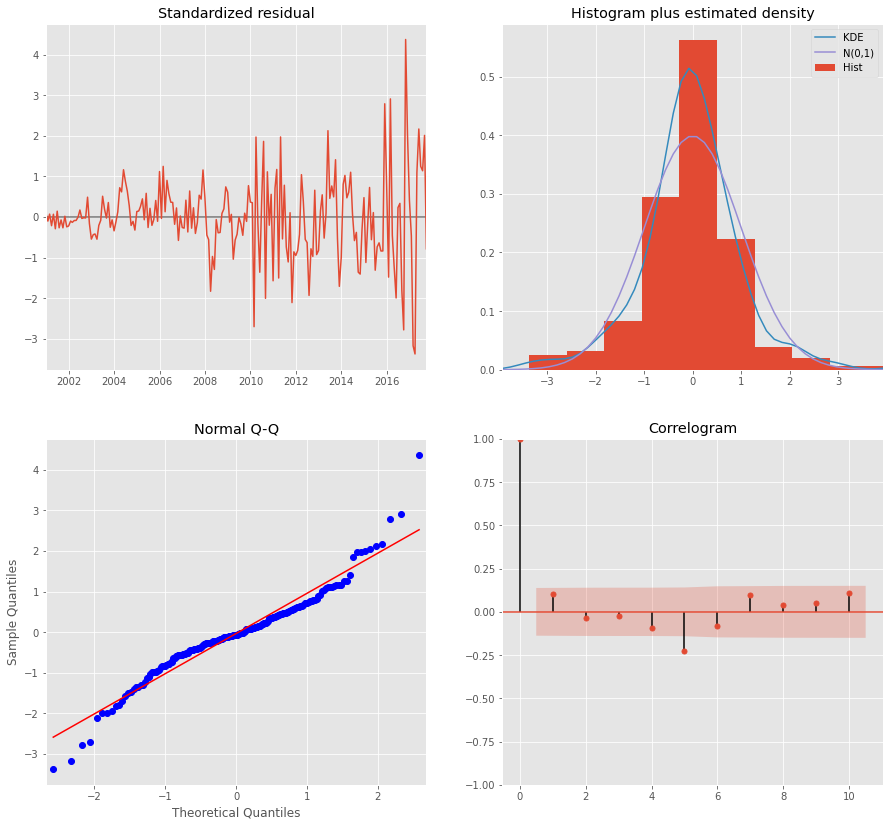

In [15]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(residuals, 
                                        order=(1, 0, 2), 
                                        seasonal_order=(1, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
display(output.summary())

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 14))
plt.show();

### Now let's have our model make some predictions.

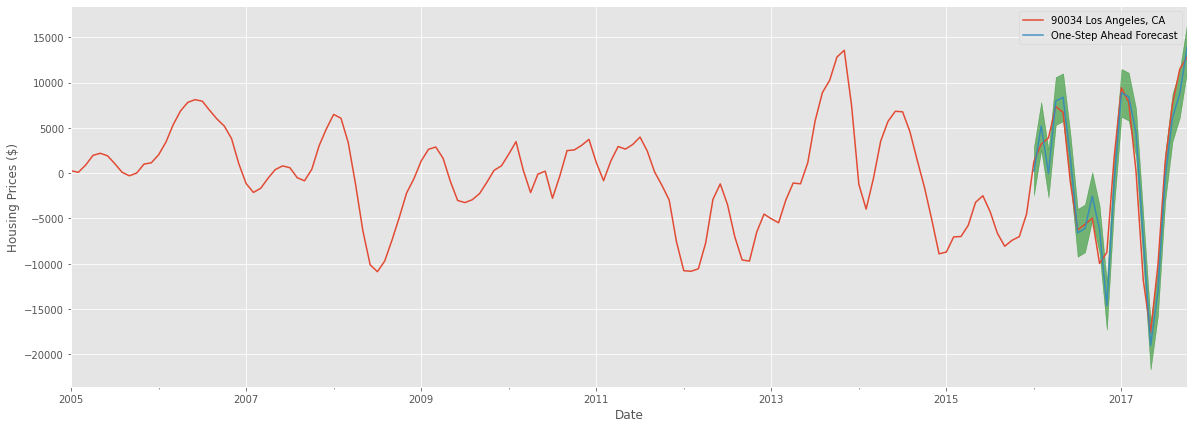

The Root Mean Squared Error of our forecasts is 2675.3


In [16]:
# One step ahead forecast starting from 2016
pred = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
# Starting from 2005 so prediction lines and confidence intervals are visible
ax = residuals['2005':].plot(label='observed', figsize=(20, 7))
pred.predicted_mean['2005':].plot(ax=ax, label='One-Step Ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_ylabel('Housing Prices ($)')
plt.legend()
plt.show()

# Compute and display the root mean square error
rmse = np.sqrt(((pd.DataFrame(pred.predicted_mean).values - residuals['2016':].values) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

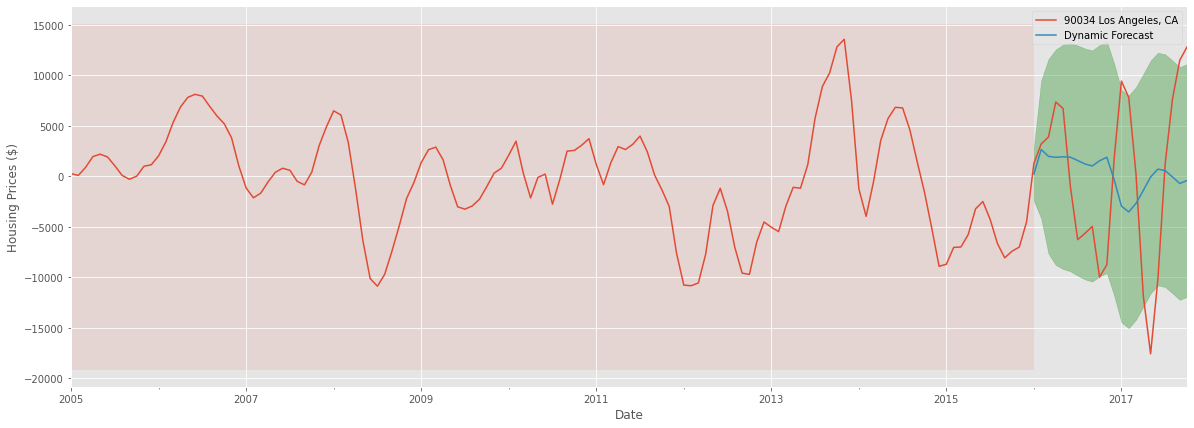

The Root Mean Squared Error of our forecasts is 8708.77


In [18]:
# Get dynamic forecast predictions
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals
ax = residuals['2005':].plot(label='observed', figsize=(20, 7))
pred_dynamic.predicted_mean['2005':].plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), alpha=.1, zorder=-1)
ax.set_ylabel('Housing Prices ($)')
plt.legend()
plt.show();

# Compute and display the root mean square error
rmse = np.sqrt(((pd.DataFrame(pred_dynamic.predicted_mean).values - residuals['2016':].values) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

### The plots and average prediction errors are looking pretty good! However, note that we are predicting on only the 'residuals' after the dataset was decomposed to achieve stationarity. We'll go ahead and add back 'trends' and 'seasonality' so that our plots can be interpreted properly.

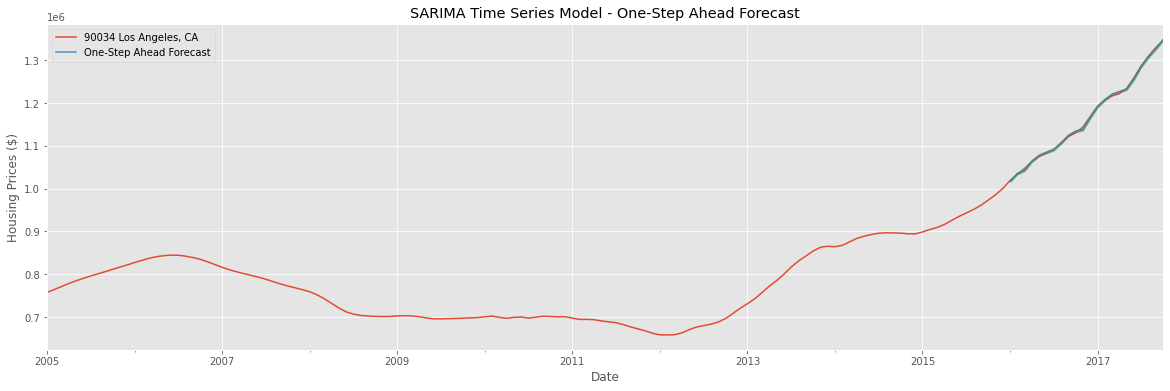

In [19]:
# One step ahead forecast with 'un-decompose' performed
pred = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()
for i in pred_conf.index:  #adding back trend, seasonal values
    pred_conf.loc[i,'lower 90034 Los Angeles, CA'] += trend.loc[i,'90034 Los Angeles, CA'] + seasonal.loc[i,'90034 Los Angeles, CA']
    pred_conf.loc[i,'upper 90034 Los Angeles, CA'] += trend.loc[i,'90034 Los Angeles, CA'] + seasonal.loc[i,'90034 Los Angeles, CA']

recompose = residuals.copy()
for i in recompose.index:  #adding back trend, seasonal values
    recompose.loc[i,'90034 Los Angeles, CA'] += trend.loc[i,'90034 Los Angeles, CA'] + seasonal.loc[i,'90034 Los Angeles, CA']

preds_adj = pred.predicted_mean
for i in preds_adj.index:  #adding back trend, seasonal values
    preds_adj[i] += trend.loc[i,'90034 Los Angeles, CA'] + seasonal.loc[i,'90034 Los Angeles, CA']

# Plot real vs predicted values along with confidence interval
ax = recompose['2005':].plot(label='observed', figsize=(20,6))
preds_adj['2005':].plot(ax=ax, label='One-Step Ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_ylabel('Housing Prices ($)')
plt.title('SARIMA Time Series Model - One-Step Ahead Forecast')
plt.legend()
plt.show();

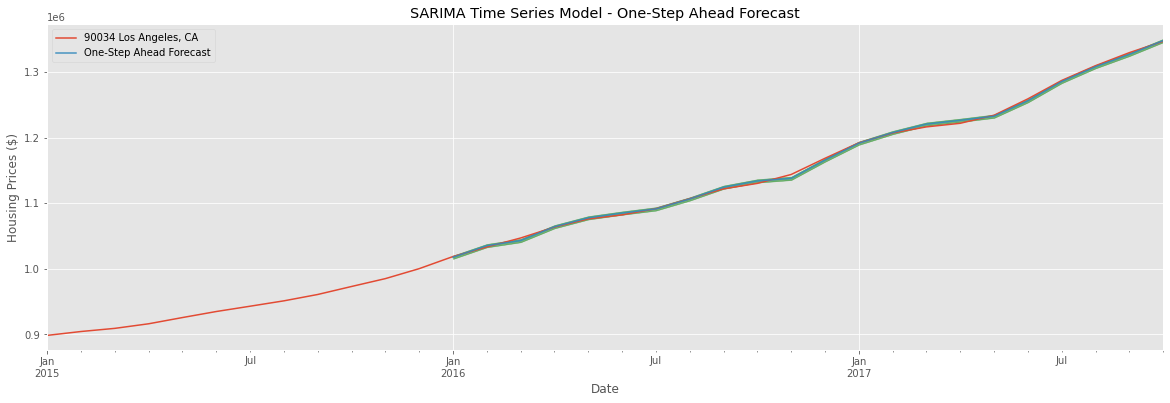

In [26]:
# Zoom in further on the prediction range
ax = recompose['2015':].plot(label='observed', figsize=(20,6))
preds_adj['2015':].plot(ax=ax, label='One-Step Ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_ylabel('Housing Prices ($)')
plt.title('SARIMA Time Series Model - One-Step Ahead Forecast')
plt.legend()
plt.show();

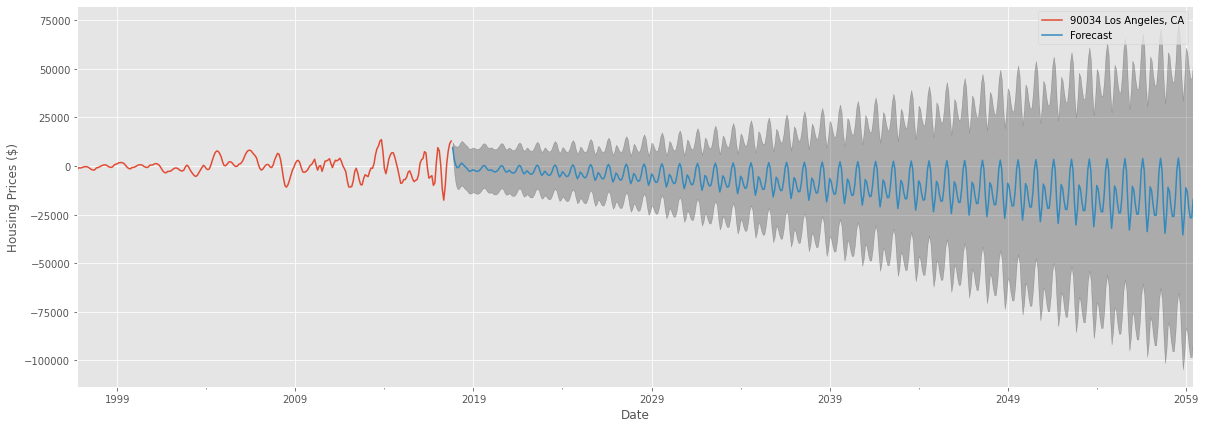

In [20]:
# Get forecast 500 steps ahead in future and confidence intervals
pred_500 = output.get_forecast(steps=500)
pred_conf = pred_500.conf_int()

ax = residuals.plot(label='observed', figsize=(20, 7))
pred_500.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_ylabel('Housing Prices ($)')
plt.legend()
plt.show()

Unfortunately for the 500 step forecast, we were not able to add back the trends and seasonality data that was separated from the residuals to properly plot using the scale of original USD housing prices. However, by examining the data separated in trend/seasonal, we are able to estimate the average predicted change per year:

In [21]:
display(seasonal.tail(50), trend.tail(50))

,"90034 Los Angeles, CA"
Date,
2014-03-01,-167.591089
2014-04-01,-305.091089
2014-05-01,-333.265693
2014-06-01,-61.241883
2014-07-01,362.964466
2014-08-01,569.115260
2014-09-01,572.686688
2014-10-01,223.263889
2014-11-01,-601.718074


,"90034 Los Angeles, CA"
Date,
2014-03-01,8.763458e+05
2014-04-01,8.803542e+05
2014-05-01,8.834125e+05
2014-06-01,8.859292e+05
2014-07-01,8.885667e+05
2014-08-01,8.915417e+05
2014-09-01,8.944833e+05
2014-10-01,8.972417e+05
2014-11-01,9.001375e+05


In [22]:
# Confirming annual sum of seasonal values
display(seasonal['2015'].sum(), seasonal['2016'].sum(), seasonal['2017'].sum())

90034 Los Angeles, CA    1.705303e-13
dtype: float64

90034 Los Angeles, CA    1.705303e-13
dtype: float64

90034 Los Angeles, CA    1.705303e-13
dtype: float64

In [23]:
# Confirm % increase in trend every month
print((trend.iloc[-7,0]-trend.iloc[-8,0])/trend.iloc[-8,0], (trend.iloc[-8,0]-trend.iloc[-9,0])/trend.iloc[-9,0],
      (trend.iloc[-9,0]-trend.iloc[-10,0])/trend.iloc[-10,0])

0.012387757683065638 0.012338961350724174 0.012348759291542248


In [24]:
1.01235**12  #calculating approximate annual increase

1.1586926347280635

So we confirmed that 'seasonal' values summed up annually is virtually zero, which makes sense. 'Trend' captured our upward linear trajectory with slightly varying increases (~1.235%) every month. This works out to about a 16% return annually.
> Annual returns of 8-12% for any investment would be considered pretty good, especially over long time horizons. 15% annual returns appear to be in line with housing in a top 10 US zip code.

## Conclusions
Although this model was created from a single top performing zip code in LA, we can confidently draw conclusions from its predictions that can be applied to other top zip codes due to their high correlation with each other. Therefore, we can assume that the ROI (assuming 2018 cost basis) would not be a differentiating factor in helping us narrow down this list.

> To make our final top 5 selections, we will choose from our top 10 based on **county tax rates, price to rent ratio and other 'standouts' from our 5 metrics**.

[County Tax Rates](https://smartasset.com/taxes/property-taxes)

LA County (Santa Monica, Culver City): 0.755%  
Alameda County (Oakland, Berkeley): 0.785%  
San Mateo County (Redwood City): 0.658%  
Philadelphia County: 0.984%

## Recommendations
Based on our final selection criteria, we have deemed the following to be our top five zip codes to invest in!

**94402 San Mateo, CA (low tax rate)**  
**94061 Redwood City, CA (low tax rate, highest recovery ROI)**  
**19125 Philadelphia, PA (very good price to rent ratio, highest overall ROI)**  
**90404 Santa Monica, CA (significantly lowest number of recovery months)**  
**90232 Culver City, CA (low entry point)**

## Future Work
See if our predictions ring true by getting updated housing data from Zillow!